# Problem Domain

This notebook uses two datasets [international-football-results-from-1872-to-2017](https://www.kaggle.com/datasets/martj42/international-football-results-from-1872-to-2017) and [fifaworldranking](https://www.kaggle.com/datasets/cashncarry/fifaworldranking)

## Data Preparation

Preparing the data to apply for feature engineering

In [1]:
import opendatasets as od

od.download("https://www.kaggle.com/datasets/cashncarry/fifaworldranking?select=fifa_ranking-2022-12-22.csv", data_dir='/tmp/')

Skipping, found downloaded files in "/tmp/fifaworldranking" (use force=True to force download)


In [2]:
#https://www.kaggle.com/code/sslp23/predicting-fifa-2022-world-cup-with-ml
from difflib import SequenceMatcher
from tqdm import tqdm

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputClassifier

In [3]:
def read_results(url):
    df = pd.read_csv(url)
    return df
    
results = read_results('https://raw.githubusercontent.com/martj42/international_results/master/results.csv')

In [4]:
results.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


In [5]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44371 entries, 0 to 44370
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        44371 non-null  object
 1   home_team   44371 non-null  object
 2   away_team   44371 non-null  object
 3   home_score  44371 non-null  int64 
 4   away_score  44371 non-null  int64 
 5   tournament  44371 non-null  object
 6   city        44371 non-null  object
 7   country     44371 non-null  object
 8   neutral     44371 non-null  bool  
dtypes: bool(1), int64(2), object(6)
memory usage: 2.8+ MB


In [6]:
results['date'] = pd.to_datetime(results['date'])

In [7]:
results.isna().sum()

date          0
home_team     0
away_team     0
home_score    0
away_score    0
tournament    0
city          0
country       0
neutral       0
dtype: int64

We can see that the dataframe does not have any null values!

In [8]:
results.dtypes

date          datetime64[ns]
home_team             object
away_team             object
home_score             int64
away_score             int64
tournament            object
city                  object
country               object
neutral                 bool
dtype: object

Read the ranking dataset from 1992 to 2022 

In [9]:
rankings = pd.read_csv('/tmp/fifaworldranking/fifa_ranking-2022-12-22.csv')

In [10]:
rankings.head()

,rank,country_full,country_abrv,total_points,previous_points,rank_change,confederation,rank_date
0,74,Madagascar,MAD,18.0,0.0,0,CAF,1992-12-31
1,52,Qatar,QAT,27.0,0.0,0,AFC,1992-12-31
2,51,Senegal,SEN,27.0,0.0,0,CAF,1992-12-31
3,50,El Salvador,SLV,28.0,0.0,0,CONCACAF,1992-12-31
4,49,Korea Republic,KOR,28.0,0.0,0,AFC,1992-12-31


In [11]:
rankings.isna().sum()

rank               0
country_full       0
country_abrv       0
total_points       0
previous_points    0
rank_change        0
confederation      0
rank_date          0
dtype: int64

In [12]:
rankings['rank_date'] = pd.to_datetime(rankings['rank_date'])

In [13]:
first_date_ranking = rankings.sort_values('rank_date').iloc[0]['rank_date']

Filter the results dataframe only from 1992

In [14]:
results = results[results['date'] >= first_date_ranking].reset_index(drop=True)

In [15]:
# lots of friendly games
results.tournament.value_counts()

Friendly                                9265
FIFA World Cup qualification            5923
UEFA Euro qualification                 1752
African Cup of Nations qualification    1350
AFC Asian Cup qualification              548
                                        ... 
Atlantic Heritage Cup                      2
CONMEBOL–UEFA Cup of Champions             2
Cup of Ancient Civilizations               2
Copa Confraternidad                        1
TIFOCO Tournament                          1
Name: tournament, Length: 95, dtype: int64

*Check if country names in results dataframe match with country names in rankings database. Adjust those that doesn't match either way.*

In [16]:
def similar(a, b):
    return np.round(SequenceMatcher(None, a, b).ratio(), 2)

def check_country_name_matchings(results, rankings):
    
    similar_country_names = {"country_A": [], 'country_B': []}
    
    results_countries = list(results.away_team.unique())
    rankings_countries = list(rankings.country_full.unique())
    diff_A = sorted(list(set(results_countries).difference(rankings_countries)))
    diff_B = sorted(list(set(rankings_countries).difference(results_countries)))

    for country_A in diff_A:
        for country_B in diff_B:
            if country_A == country_B:
                continue
            similarity = similar(country_A, country_B)
            if similarity > 0.75:
                print(f'Country {country_A} to {country_B} is similar with a probability of', similarity)
                similar_country_names['country_A'].append(country_A)
                similar_country_names['country_B'].append(country_B)
                
    return similar_country_names
                
    
similar_country_names = check_country_name_matchings(results, rankings)

Country Cape Verde to Cabo Verde is similar with a probability of 0.8
Country Saint Kitts and Nevis to St Kitts and Nevis is similar with a probability of 0.92
Country Saint Kitts and Nevis to St. Kitts and Nevis is similar with a probability of 0.9
Country Saint Lucia to St Lucia is similar with a probability of 0.84
Country Saint Lucia to St. Lucia is similar with a probability of 0.8
Country Saint Vincent and the Grenadines to St Vincent and the Grenadines is similar with a probability of 0.95
Country Saint Vincent and the Grenadines to St. Vincent / Grenadines is similar with a probability of 0.79
Country Saint Vincent and the Grenadines to St. Vincent and the Grenadines is similar with a probability of 0.94
Country United States Virgin Islands to US Virgin Islands is similar with a probability of 0.76


Replace country names on rankings based on the dictionary

In [17]:
for c_A, c_B in zip(similar_country_names['country_A'], similar_country_names['country_B']):
    rankings.country_full.str.replace(c_A, c_B)
    
#manually replace some countries that didnt make the cut
rankings['country'] = rankings.country_full.str.replace('USA', 'United States').str.replace('Korea Republic', 'South Korea').str.replace('IR Iran', 'Iran')

In [18]:
rankings = rankings.set_index(['rank_date']).groupby(['country'], group_keys=False).resample('D').first().fillna(method='ffill').reset_index()

In [19]:
rankings = rankings[["country_full", "total_points", "previous_points", "rank", "rank_change", "rank_date"]]

In [20]:
df = results.merge(rankings, left_on=['date', 'home_team'], right_on=['rank_date', 'country_full']).drop(['rank_date', 'country_full'], axis=1)
df = df.merge(rankings, left_on=['date', 'away_team'], right_on=['rank_date', 'country_full'], suffixes=("_home", "_away")).drop(['rank_date', 'country_full'], axis=1)

In [21]:
df[df['home_team']=='Albania'].tail(3)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,total_points_home,previous_points_home,rank_home,rank_change_home,total_points_away,previous_points_away,rank_away,rank_change_away
21493,2022-11-09,Albania,Qatar,0,1,Friendly,Marbella,Spain,True,1354.11,1361.81,66.0,0.0,1439.89,1441.97,50.0,2.0
21502,2022-11-16,Albania,Italy,1,3,Friendly,Tirana,Albania,False,1354.11,1361.81,66.0,0.0,1726.14,1713.86,6.0,-1.0
21544,2022-11-19,Albania,Armenia,2,0,Friendly,Tirana,Albania,False,1354.11,1361.81,66.0,0.0,1233.93,1242.42,93.0,1.0


In [22]:
len(df)

21630

Data is ready

## Feature Engineering

Create possible features that have impact on predicting football games.

In [23]:
def result(home_score, away_score):
    if home_score > away_score:
        return pd.Series([0, 3, 0])
    elif home_score < away_score:
        return pd.Series([1, 0, 3])
    else:
        return pd.Series([2, 1, 1])
    
results = df.apply(lambda x: result(x['home_score'], x['away_score']), axis=1)

In [24]:
df[["result", "home_team_points", "away_team_points"]] = results

Game points are 3 for win, 1 for draw and 0 for lose

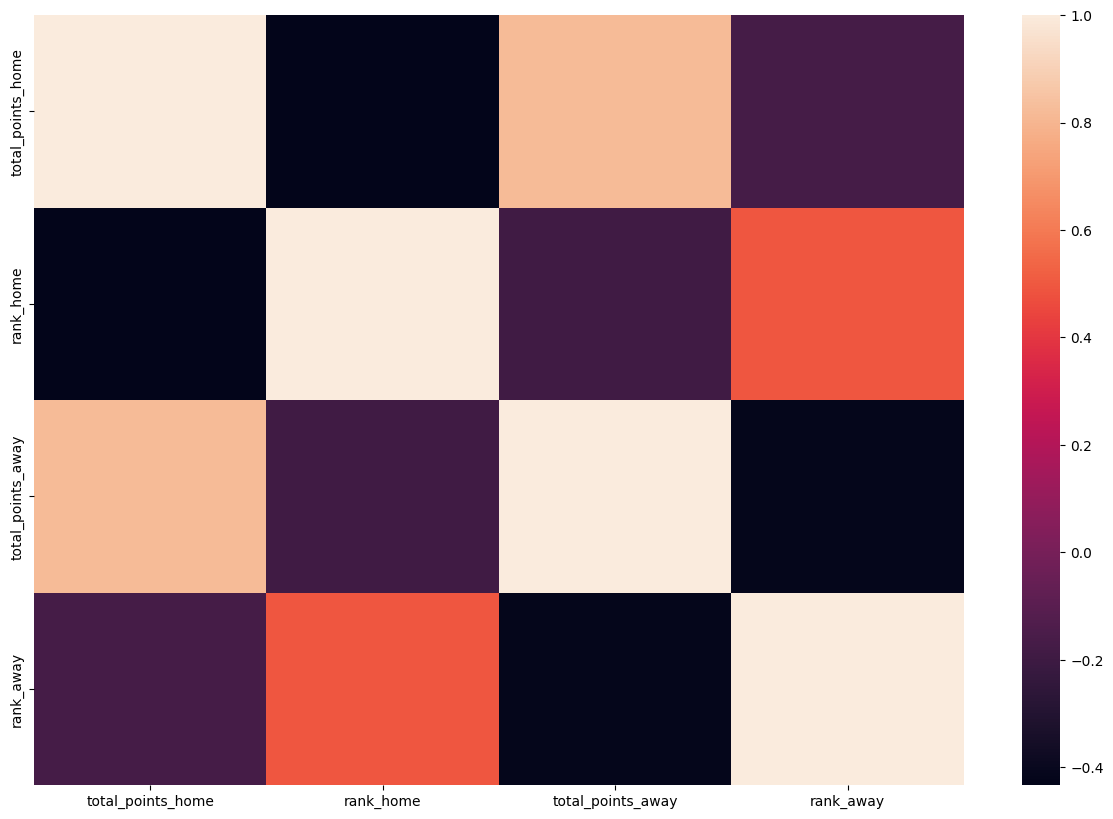

In [25]:
plt.figure(figsize=(15, 10))
sns.heatmap(df[['total_points_home', 'rank_home', 'total_points_away', 'rank_away']].corr())
plt.show()

Creating columns that will help in creation of the features: ranking difference, points won at the game vs/ team faced_rank, goals difference in the game

In [26]:
df['rank_diff'] = df['rank_home'] - df['rank_away']
df['score_diff'] = df['home_score'] - df['away_score']
df['points_home_by_rank'] = df['home_team_points']/df['rank_away']
df['points_away_by_rank'] = df['away_team_points']/df['rank_home']

In [27]:
df.tail(1)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,total_points_home,previous_points_home,rank_home,rank_change_home,total_points_away,previous_points_away,rank_away,rank_change_away,result,home_team_points,away_team_points,rank_diff,score_diff,points_home_by_rank,points_away_by_rank
21629,2022-12-18,Argentina,France,3,3,FIFA World Cup,Lusail,Qatar,True,1773.88,1770.65,3.0,0.0,1759.78,1764.85,4.0,0.0,2,1,1,-1.0,0,0.25,0.333333


In order to create the features, I'll separate the dataset in home team's and away team's dataset, unify them and calculate the past game values. After that, I'll separate again and merge them, retrieving the original dataset. This proccess optimizes the creation of the features.

In [28]:
home_team = df[["date", "home_team", "home_score", "away_score", "tournament", "rank_home", "rank_away","rank_change_home", "total_points_home", "result", "rank_diff", "points_home_by_rank", "home_team_points"]]

away_team = df[["date", "away_team", "away_score", "home_score", "tournament", "rank_away", "rank_home","rank_change_away", "total_points_away", "result", "rank_diff", "points_away_by_rank", "away_team_points"]]

In [29]:
home_team.columns = [h.replace("home_", "").replace("_home", "").replace("away_", "suf_").replace("_away", "_suf") for h in home_team.columns]

away_team.columns = [a.replace("away_", "").replace("_away", "").replace("home_", "suf_").replace("_home", "_suf") for a in away_team.columns]

In [30]:
team_stats_raw = pd.concat([home_team, away_team]).copy()
team_stats_raw

,date,team,score,suf_score,tournament,rank,rank_suf,rank_change,total_points,result,rank_diff,points_by_rank,team_points
0,1993-01-01,Ghana,1,1,Friendly,39.0,69.0,0.0,34.00,2,-30.0,0.014493,1
1,1993-01-02,Gabon,1,1,Friendly,55.0,97.0,0.0,27.00,2,-42.0,0.010309,1
2,1993-01-03,Burkina Faso,1,0,Friendly,97.0,69.0,0.0,11.00,0,28.0,0.043478,3
3,1993-01-03,Gabon,2,3,Friendly,55.0,39.0,0.0,27.00,1,16.0,0.000000,0
4,1993-01-08,Uganda,3,1,Friendly,92.0,80.0,0.0,12.00,0,12.0,0.037500,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21625,2022-12-14,Maldives,0,3,Friendly,154.0,146.0,-2.0,1026.09,0,-8.0,0.000000,0
21626,2022-12-14,Philippines,0,1,Friendly,133.0,96.0,-1.0,1115.13,0,-37.0,0.000000,0
21627,2022-12-17,Morocco,1,2,FIFA World Cup,22.0,12.0,-1.0,1563.50,0,-10.0,0.000000,0
21628,2022-12-17,Maldives,1,3,Friendly,154.0,160.0,-2.0,1026.09,0,6.0,0.000000,0


Now we have the data to create predictive feature

In [31]:
stats = []

for index, row in tqdm(team_stats_raw.iterrows()):
    team = row['team']
    date = row['date']
    past_games = team_stats_raw.loc[(team_stats_raw['team'] == team) & (team_stats_raw['date'] < date)].sort_values(by=['date'], ascending=False)
    last_5 = past_games.head(5)
    
    goals = past_games['score'].mean()
    goals_last_5 = last_5['score'].mean()
    
    goals_suf = past_games['suf_score'].mean()
    goals_suf_last_5 = last_5['suf_score'].mean()
    
    rank = past_games['rank_suf'].mean()
    rank_last_5 = last_5['rank_suf'].mean()
    
    if len(last_5) > 0:
        points = past_games["total_points"].values[0] - past_games["total_points"].values[-1]
        points_last_5 = last_5["total_points"].values[0] - last_5["total_points"].values[-1] 
    else:
        points = 0
        points_last_5 = 0
        
        
    team_points = past_games['team_points'].mean()
    team_points_last_5 = last_5['team_points'].mean()
    
    points_by_rank = past_games['points_by_rank'].mean()
    points_by_rank_last_5 = last_5['points_by_rank'].mean()
    
    stats.append([goals, goals_last_5, goals_suf, goals_suf_last_5, rank, rank_last_5, points, points_last_5, team_points, team_points_last_5, points_by_rank, points_by_rank_last_5])    

43260it [01:46, 405.52it/s]


In [32]:
stats_cols = ["goals_mean", "goals_mean_last_5", "goals_suf_mean",
              "goals_suf_mean_last_5", "rank_mean", "rank_mean_last_5",
              "points_mean", "points_mean_last_5", "team_points_mean",
              "team_points_mean_last_5", "points_rank_mean",
              "points_rank_mean_last_5"]
stats_df = pd.DataFrame(stats, columns=stats_cols)
full_df = pd.concat([team_stats_raw.reset_index(drop=True), stats_df], axis=1, ignore_index=True)
full_df.columns = list(team_stats_raw.columns) + stats_cols

In [33]:
home_team_stats = full_df.iloc[:int(full_df.shape[0]/2),:]
away_team_stats = full_df.iloc[int(full_df.shape[0]/2):,:]

In [34]:
home_team_stats = home_team_stats[home_team_stats.columns[-12:]]
away_team_stats = away_team_stats[away_team_stats.columns[-12:]]

In [35]:
home_team_stats.columns = ['home_'+str(col) for col in home_team_stats.columns]
away_team_stats.columns = ['away_'+str(col) for col in away_team_stats.columns]

In [36]:
match_stats = pd.concat([home_team_stats, away_team_stats.reset_index(drop=True)], axis=1, ignore_index=False)

In [37]:
full_df = pd.concat([df, match_stats.reset_index(drop=True)], axis=1, ignore_index=False)

Now, to quantify game importance, is created a column that finds competition of the game.

In [39]:
full_df['is_friendly'] = full_df['tournament'].apply(lambda x: 1 if x=='Friendly' else 0)

In [40]:
full_df = pd.get_dummies(full_df, columns=["is_friendly"])

In [41]:
full_df.head(2)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,total_points_home,previous_points_home,rank_home,rank_change_home,total_points_away,previous_points_away,rank_away,rank_change_away,result,home_team_points,away_team_points,rank_diff,score_diff,points_home_by_rank,points_away_by_rank,home_goals_mean,home_goals_mean_last_5,home_goals_suf_mean,home_goals_suf_mean_last_5,home_rank_mean,home_rank_mean_last_5,home_points_mean,home_points_mean_last_5,home_team_points_mean,home_team_points_mean_last_5,home_points_rank_mean,home_points_rank_mean_last_5,away_goals_mean,away_goals_mean_last_5,away_goals_suf_mean,away_goals_suf_mean_last_5,away_rank_mean,away_rank_mean_last_5,away_points_mean,away_points_mean_last_5,away_team_points_mean,away_team_points_mean_last_5,away_points_rank_mean,away_points_rank_mean_last_5,is_friendly_0,is_friendly_1
0,1993-01-01,Ghana,Mali,1,1,Friendly,Libreville,Gabon,True,34.0,0.0,39.0,0.0,22.0,0.0,69.0,0.0,2,1,1,-30.0,0,0.014493,0.025641,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0,1
1,1993-01-02,Gabon,Burkina Faso,1,1,Friendly,Libreville,Gabon,False,27.0,0.0,55.0,0.0,11.0,0.0,97.0,0.0,2,1,1,-42.0,0,0.010309,0.018182,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0,1


And, after that, we select only columns that will help in Features' analysis.

In [42]:
base_df = full_df.drop(['tournament', 'city', 'country', 'neutral', 'total_points_home', 'previous_points_home', 'total_points_away', 'previous_points_away', 'home_team_points', 'away_team_points', 'score_diff', 'points_home_by_rank', 'points_away_by_rank'], axis=1)

In [43]:
base_df.tail(2)

,date,home_team,away_team,home_score,away_score,rank_home,rank_change_home,rank_away,rank_change_away,result,rank_diff,home_goals_mean,home_goals_mean_last_5,home_goals_suf_mean,home_goals_suf_mean_last_5,home_rank_mean,home_rank_mean_last_5,home_points_mean,home_points_mean_last_5,home_team_points_mean,home_team_points_mean_last_5,home_points_rank_mean,home_points_rank_mean_last_5,away_goals_mean,away_goals_mean_last_5,away_goals_suf_mean,away_goals_suf_mean_last_5,away_rank_mean,away_rank_mean_last_5,away_points_mean,away_points_mean_last_5,away_team_points_mean,away_team_points_mean_last_5,away_points_rank_mean,away_points_rank_mean_last_5,is_friendly_0,is_friendly_1
21628,2022-12-17,Singapore,Maldives,3,1,160.0,1.0,154.0,-2.0,0,6.0,1.290323,1.4,1.491039,1.6,120.835125,122.6,991.75,-7.52,1.279570,1.0,0.009695,0.00724,1.435583,1.4,2.01227,1.6,143.061350,161.4,1024.09,0.59,1.104294,1.8,0.006748,0.009363,0,1
21629,2022-12-18,Argentina,France,3,3,3.0,0.0,4.0,0.0,2,-1.0,1.817460,2.2,0.888889,0.6,36.357143,19.4,1722.88,0.00,1.989418,2.6,0.168277,0.16002,1.816000,1.8,0.72000,0.8,38.466667,18.6,1713.78,0.00,2.096000,2.4,0.165517,0.230350,1,0


In [44]:
base_df.isna().sum()

date                              0
home_team                         0
away_team                         0
home_score                        0
away_score                        0
rank_home                         0
rank_change_home                  0
rank_away                         0
rank_change_away                  0
result                            0
rank_diff                         0
home_goals_mean                  91
home_goals_mean_last_5           91
home_goals_suf_mean              91
home_goals_suf_mean_last_5       91
home_rank_mean                   91
home_rank_mean_last_5            91
home_points_mean                  0
home_points_mean_last_5           0
home_team_points_mean            91
home_team_points_mean_last_5     91
home_points_rank_mean            91
home_points_rank_mean_last_5     91
away_goals_mean                 107
away_goals_mean_last_5          107
away_goals_suf_mean             107
away_goals_suf_mean_last_5      107
away_rank_mean              

## Data Analysis

Analyze all features that were created and check if they have predictive power.

If they don't, we need to create some that have, like differences of home and away teams.

In [45]:
df = base_df.dropna()

In [46]:
df['target'] = df['result'].apply(lambda x: 1 if x==2 else x)

/var/folders/tr/qq7qwqx91mq6jv07l_3ksqlm0000gn/T/ipykernel_20548/1606294925.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'] = df['result'].apply(lambda x: 1 if x==2 else x)


Analysis that will be made:

Violin and boxplot to analyze if the features have different distributions according to the target
Scatter plots to analyze correlations

In [47]:
data1 = df[['rank_diff', 'rank_change_home', 'rank_change_away'] + list(df.columns[11:19].values) + ['target']]
data2 = df[df.columns[19:]]

In [48]:
scaled = (data1[:-1] -data1[:-1].mean()) / data1[:-1].std()
scaled['target'] = data1['target']
violin1 = pd.melt(scaled, id_vars='target', var_name='features', value_name='value')

scaled = (data2[:-1] -data2[:-1].mean()) / data2[:-1].std()
scaled['target'] = data2['target']
violin2 = pd.melt(scaled, id_vars='target', var_name='features', value_name='value')

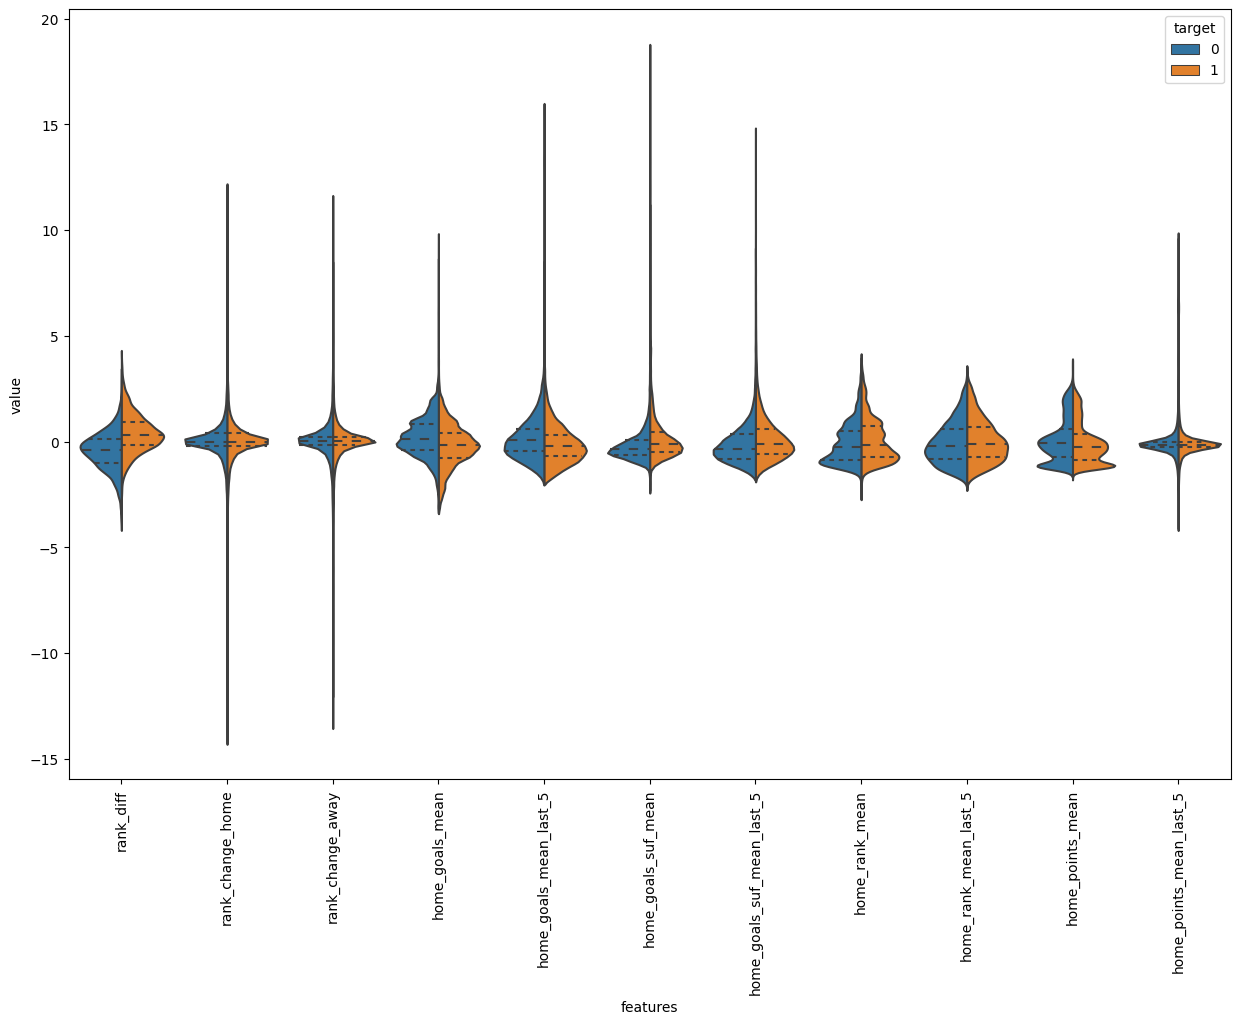

In [49]:
plt.figure(figsize=(15, 10))
sns.violinplot(x='features', y='value', hue='target', data=violin1, split=True, inner='quart')
plt.xticks(rotation=90)
plt.show()

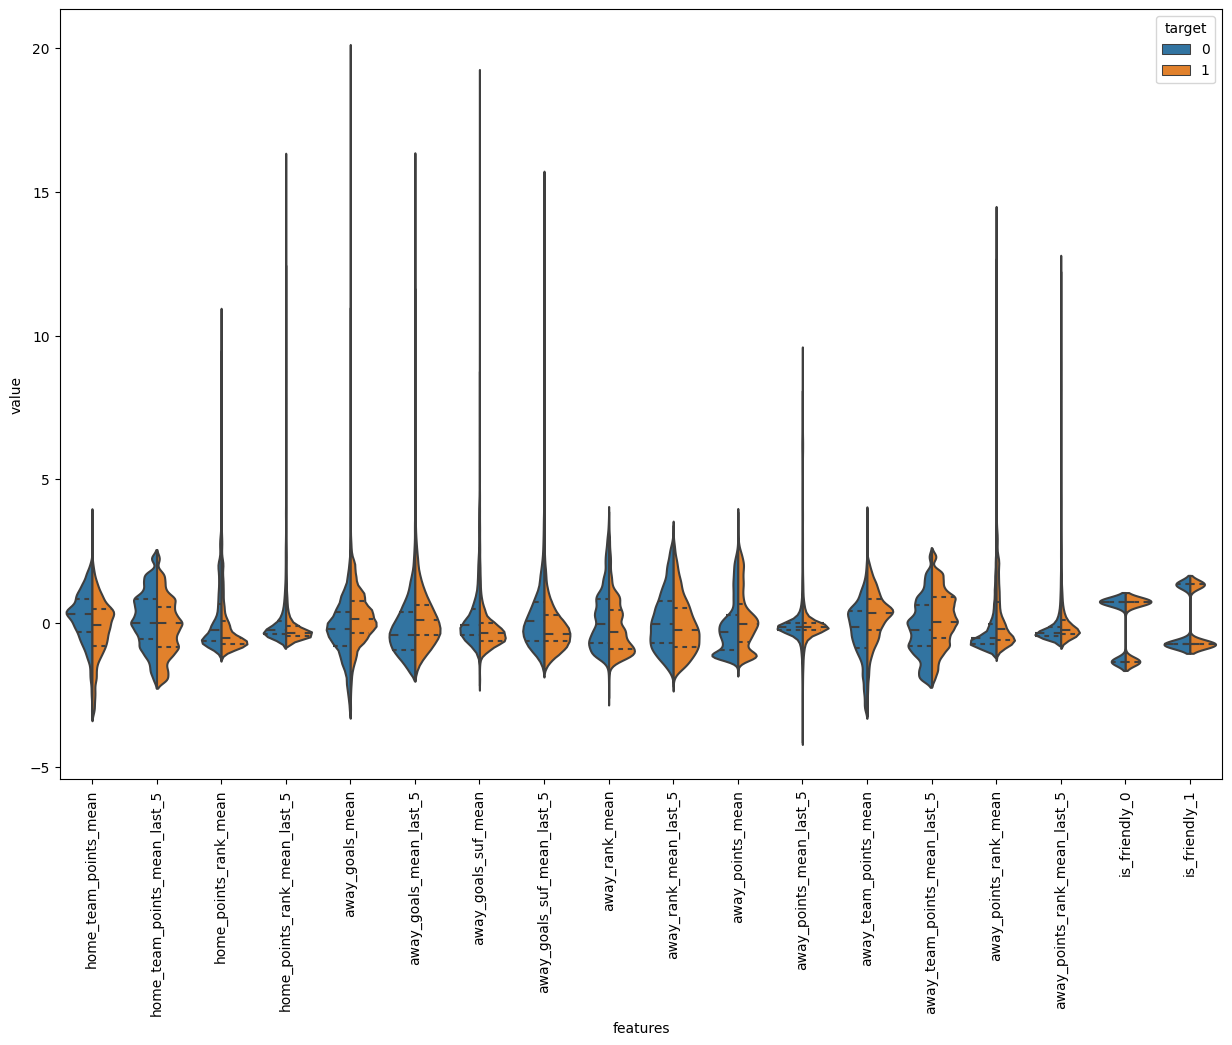

In [50]:
plt.figure(figsize=(15, 10))
sns.violinplot(x='features', y='value', hue='target', data=violin2, split=True, inner='quart')
plt.xticks(rotation=90)
plt.show()

With the plots, we find that rank difference is the only good separator of the data. But, we can create features that get the differences between home and away team and analyze if they are good separating the data.

In [51]:
diff = df.copy()

In [52]:
diff.loc[:, 'goals_diff'] = diff['home_goals_mean'] - diff['away_goals_mean']
diff.loc[:, 'goals_diff_last_5'] = diff['home_goals_mean_last_5'] - diff['away_goals_mean_last_5']
diff.loc[:, 'goals_suf_diff'] = diff['home_goals_suf_mean'] - diff['away_goals_suf_mean']
diff.loc[:, 'goals_suff_diff_last_5'] = diff['home_goals_mean_last_5'] - diff['away_goals_mean_last_5']
diff.loc[:, 'goals_made_suf_diff'] = diff["home_goals_mean"] - diff["away_goals_suf_mean"]
diff.loc[:, 'goals_made_suf_diff_last_5'] = diff["home_goals_mean_last_5"] - diff["away_goals_suf_mean_last_5"]
diff.loc[:, 'goals_suf_made_diff'] = diff["home_goals_suf_mean"] - diff["away_goals_mean"]
diff.loc[:, 'goals_suf_made_diff_last_5'] = diff["home_goals_suf_mean_last_5"] - diff["away_goals_mean_last_5"]

In [53]:
diff

,date,home_team,away_team,home_score,away_score,rank_home,rank_change_home,rank_away,rank_change_away,result,rank_diff,home_goals_mean,home_goals_mean_last_5,home_goals_suf_mean,home_goals_suf_mean_last_5,home_rank_mean,home_rank_mean_last_5,home_points_mean,home_points_mean_last_5,home_team_points_mean,home_team_points_mean_last_5,home_points_rank_mean,home_points_rank_mean_last_5,away_goals_mean,away_goals_mean_last_5,away_goals_suf_mean,away_goals_suf_mean_last_5,away_rank_mean,away_rank_mean_last_5,away_points_mean,away_points_mean_last_5,away_team_points_mean,away_team_points_mean_last_5,away_points_rank_mean,away_points_rank_mean_last_5,is_friendly_0,is_friendly_1,target,goals_diff,goals_diff_last_5,goals_suf_diff,goals_suff_diff_last_5,goals_made_suf_diff,goals_made_suf_diff_last_5,goals_suf_made_diff,goals_suf_made_diff_last_5
2,1993-01-03,Burkina Faso,Mali,1,0,97.0,0.0,69.0,0.0,0,28.0,1.000000,1.0,1.000000,1.0,55.000000,55.0,0.00,0.00,1.000000,1.0,0.018182,0.018182,1.000000,1.0,1.000000,1.0,39.000000,39.0,0.00,0.00,1.000000,1.0,0.025641,0.025641,0,1,0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
3,1993-01-03,Gabon,Ghana,2,3,55.0,0.0,39.0,0.0,1,16.0,1.000000,1.0,1.000000,1.0,97.000000,97.0,0.00,0.00,1.000000,1.0,0.010309,0.010309,1.000000,1.0,1.000000,1.0,69.000000,69.0,0.00,0.00,1.000000,1.0,0.014493,0.014493,0,1,1,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
10,1993-01-10,Uganda,Tanzania,2,0,92.0,0.0,80.0,0.0,0,12.0,3.000000,3.0,1.000000,1.0,80.000000,80.0,0.00,0.00,3.000000,3.0,0.037500,0.037500,1.000000,1.0,3.000000,3.0,92.000000,92.0,0.00,0.00,0.000000,0.0,0.000000,0.000000,0,1,0,2.000000,2.0,-2.000000,2.0,0.000000,0.0,0.000000,0.0
18,1993-01-17,Togo,Zimbabwe,1,2,101.0,0.0,54.0,0.0,1,47.0,0.000000,0.0,0.000000,0.0,79.000000,79.0,0.00,0.00,1.000000,1.0,0.012658,0.012658,1.000000,1.0,1.000000,1.0,102.000000,102.0,0.00,0.00,1.000000,1.0,0.009804,0.009804,1,0,1,-1.000000,-1.0,-1.000000,-1.0,-1.000000,-1.0,-1.000000,-1.0
23,1993-01-22,Cameroon,Finland,0,0,22.0,0.0,44.0,0.0,2,-22.0,0.000000,0.0,0.000000,0.0,104.000000,104.0,0.00,0.00,1.000000,1.0,0.009615,0.009615,0.000000,0.0,0.000000,0.0,143.000000,143.0,0.00,0.00,1.000000,1.0,0.006993,0.006993,1,0,1,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21625,2022-12-14,Malaysia,Maldives,3,0,146.0,-2.0,154.0,-2.0,0,-8.0,1.394052,2.0,1.472119,0.8,124.602230,134.8,1049.32,27.26,1.252788,1.6,0.009494,0.010218,1.444444,1.4,2.006173,1.6,143.043210,154.4,1016.25,-7.25,1.111111,1.8,0.006789,0.009363,0,1,0,-0.050392,0.6,-0.534054,0.6,-0.612121,0.4,0.027675,-0.6
21626,2022-12-14,Vietnam,Philippines,1,0,96.0,-1.0,133.0,-1.0,0,-37.0,1.699482,2.0,1.404145,0.4,124.756477,103.0,1214.84,0.29,1.481865,2.0,0.011332,0.022238,1.162651,0.2,1.843373,1.6,141.626506,150.4,1115.89,-12.02,1.126506,0.8,0.006968,0.004550,0,1,0,0.536831,1.8,-0.439228,1.8,-0.143892,0.4,0.241494,0.2
21627,2022-12-17,Croatia,Morocco,2,1,12.0,-3.0,22.0,-1.0,0,-10.0,1.701587,1.2,0.974603,1.2,48.114286,14.2,1638.64,0.00,1.850794,1.2,0.096133,0.322967,1.555911,1.0,0.715655,0.6,70.907348,12.6,1531.50,0.00,1.862620,2.0,0.038888,0.409872,1,0,0,0.145677,0.2,0.258948,0.2,0.985932,0.6,-0.581307,0.2
21628,2022-12-17,Singapore,Maldives,3,1,160.0,1.0,154.0,-2.0,0,6.0,1.290323,1.4,1.491039,1.6,120.835125,122.6,991.75,-7.52,1.279570,1.0,0.009695,0.007240,1.435583,1.4,2.012270,1.6,143.061350,161.4,1024.09,0.59,1.104294,1.8,0.006748,0.009363,0,1,0,-0.145260,0.0,-0.521231,0.0,-0.721947,-0.2,0.055457,0.2


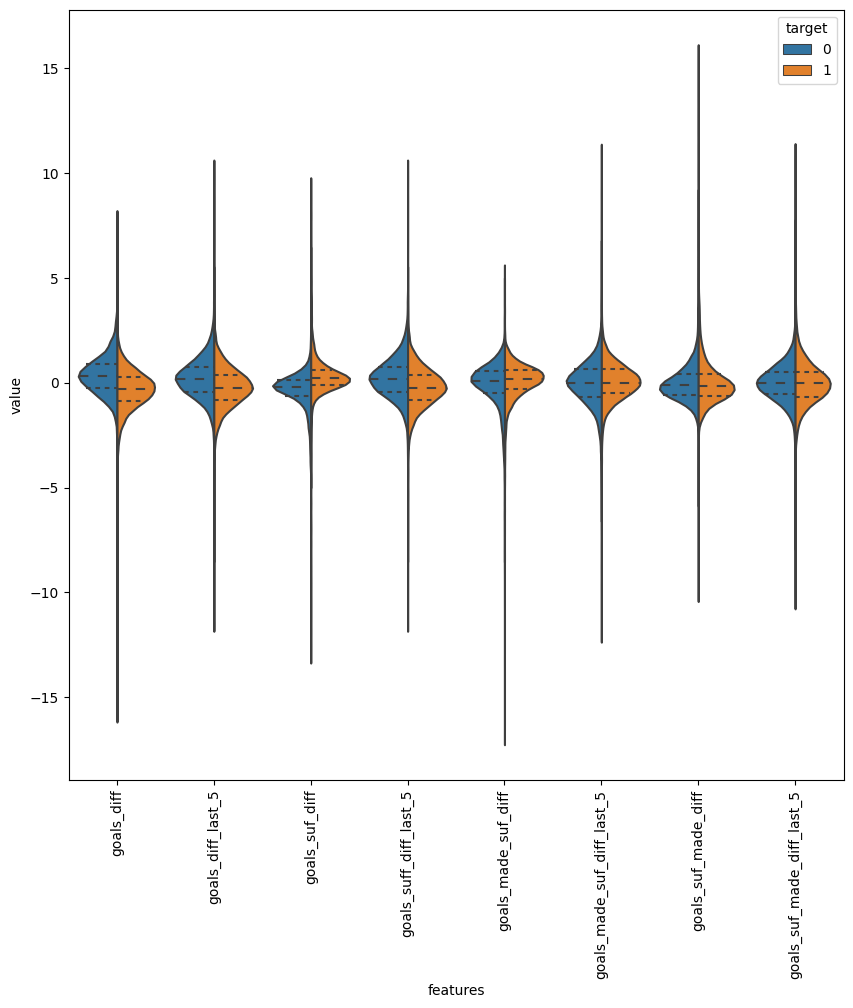

In [54]:
data_diffs = diff.iloc[:, -8:]
scaled = (data_diffs - data_diffs.mean()) / data_diffs.std()
scaled["target"] = data2["target"]
violin = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

plt.figure(figsize=(10,10))
sns.violinplot(x="features", y="value", hue="target", data=violin,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

With that plot we see that goal differences are good seperators and goals suffered differences too.

Now we have five features.

* rank diff
* goals_diff
* goals_diff_last_5
* goals_suf_diff
* goals_suff_diff_last_5

We can create other features, like differences of points_made by rank and differences of rank faced

In [55]:
diff.loc[:, "diff_points"] = diff["home_team_points_mean"] - diff["away_team_points_mean"]
diff.loc[:, "diff_points_last_5"] = diff["home_team_points_mean_last_5"] - diff["away_team_points_mean_last_5"]
diff.loc[:, "diff_points_rank"] = diff["home_points_rank_mean"] - diff["away_points_rank_mean"]
diff.loc[:, "diff_points_rank_last_5"] = diff["home_points_rank_mean_last_5"] - diff["away_points_rank_mean_last_5"]

In [56]:
diff.loc[:, "diff_rank_agst"] = diff["home_rank_mean"] - diff["away_rank_mean"]
diff.loc[:, "diff_rank_agst_last_5"] = diff["home_rank_mean_last_5"] - diff["away_rank_mean_last_5"]

In [57]:
diff

,date,home_team,away_team,home_score,away_score,rank_home,rank_change_home,rank_away,rank_change_away,result,rank_diff,home_goals_mean,home_goals_mean_last_5,home_goals_suf_mean,home_goals_suf_mean_last_5,home_rank_mean,home_rank_mean_last_5,home_points_mean,home_points_mean_last_5,home_team_points_mean,home_team_points_mean_last_5,home_points_rank_mean,home_points_rank_mean_last_5,away_goals_mean,away_goals_mean_last_5,...,away_rank_mean,away_rank_mean_last_5,away_points_mean,away_points_mean_last_5,away_team_points_mean,away_team_points_mean_last_5,away_points_rank_mean,away_points_rank_mean_last_5,is_friendly_0,is_friendly_1,target,goals_diff,goals_diff_last_5,goals_suf_diff,goals_suff_diff_last_5,goals_made_suf_diff,goals_made_suf_diff_last_5,goals_suf_made_diff,goals_suf_made_diff_last_5,diff_points,diff_points_last_5,diff_points_rank,diff_points_rank_last_5,diff_rank_agst,diff_rank_agst_last_5
2,1993-01-03,Burkina Faso,Mali,1,0,97.0,0.0,69.0,0.0,0,28.0,1.000000,1.0,1.000000,1.0,55.000000,55.0,0.00,0.00,1.000000,1.0,0.018182,0.018182,1.000000,1.0,...,39.000000,39.0,0.00,0.00,1.000000,1.0,0.025641,0.025641,0,1,0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,-0.007459,-0.007459,16.000000,16.0
3,1993-01-03,Gabon,Ghana,2,3,55.0,0.0,39.0,0.0,1,16.0,1.000000,1.0,1.000000,1.0,97.000000,97.0,0.00,0.00,1.000000,1.0,0.010309,0.010309,1.000000,1.0,...,69.000000,69.0,0.00,0.00,1.000000,1.0,0.014493,0.014493,0,1,1,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,-0.004183,-0.004183,28.000000,28.0
10,1993-01-10,Uganda,Tanzania,2,0,92.0,0.0,80.0,0.0,0,12.0,3.000000,3.0,1.000000,1.0,80.000000,80.0,0.00,0.00,3.000000,3.0,0.037500,0.037500,1.000000,1.0,...,92.000000,92.0,0.00,0.00,0.000000,0.0,0.000000,0.000000,0,1,0,2.000000,2.0,-2.000000,2.0,0.000000,0.0,0.000000,0.0,3.000000,3.0,0.037500,0.037500,-12.000000,-12.0
18,1993-01-17,Togo,Zimbabwe,1,2,101.0,0.0,54.0,0.0,1,47.0,0.000000,0.0,0.000000,0.0,79.000000,79.0,0.00,0.00,1.000000,1.0,0.012658,0.012658,1.000000,1.0,...,102.000000,102.0,0.00,0.00,1.000000,1.0,0.009804,0.009804,1,0,1,-1.000000,-1.0,-1.000000,-1.0,-1.000000,-1.0,-1.000000,-1.0,0.000000,0.0,0.002854,0.002854,-23.000000,-23.0
23,1993-01-22,Cameroon,Finland,0,0,22.0,0.0,44.0,0.0,2,-22.0,0.000000,0.0,0.000000,0.0,104.000000,104.0,0.00,0.00,1.000000,1.0,0.009615,0.009615,0.000000,0.0,...,143.000000,143.0,0.00,0.00,1.000000,1.0,0.006993,0.006993,1,0,1,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.002622,0.002622,-39.000000,-39.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21625,2022-12-14,Malaysia,Maldives,3,0,146.0,-2.0,154.0,-2.0,0,-8.0,1.394052,2.0,1.472119,0.8,124.602230,134.8,1049.32,27.26,1.252788,1.6,0.009494,0.010218,1.444444,1.4,...,143.043210,154.4,1016.25,-7.25,1.111111,1.8,0.006789,0.009363,0,1,0,-0.050392,0.6,-0.534054,0.6,-0.612121,0.4,0.027675,-0.6,0.141677,-0.2,0.002704,0.000855,-18.440979,-19.6
21626,2022-12-14,Vietnam,Philippines,1,0,96.0,-1.0,133.0,-1.0,0,-37.0,1.699482,2.0,1.404145,0.4,124.756477,103.0,1214.84,0.29,1.481865,2.0,0.011332,0.022238,1.162651,0.2,...,141.626506,150.4,1115.89,-12.02,1.126506,0.8,0.006968,0.004550,0,1,0,0.536831,1.8,-0.439228,1.8,-0.143892,0.4,0.241494,0.2,0.355359,1.2,0.004364,0.017688,-16.870029,-47.4
21627,2022-12-17,Croatia,Morocco,2,1,12.0,-3.0,22.0,-1.0,0,-10.0,1.701587,1.2,0.974603,1.2,48.114286,14.2,1638.64,0.00,1.850794,1.2,0.096133,0.322967,1.555911,1.0,...,70.907348,12.6,1531.50,0.00,1.862620,2.0,0.038888,0.409872,1,0,0,0.145677,0.2,0.258948,0.2,0.985932,0.6,-0.581307,0.2,-0.011826,-0.8,0.057246,-0.086905,-22.793063,1.6
21628,2022-12-17,Singapore,Maldives,3,1,160.0,1.0,154.0,-2.0,0,6.0,1.290323,1.4,1.491039,1.6,120.835125,122.6,991.75,-7.52,1.279570,1.0,0.009695,0.007240,1.435583,1.4,...,143.061350,161.4,1024.09,0.59,1.104294,1.8,0.006748,0.009363,0,1,0,-0.1

In [58]:
diff.loc[:, "goals_per_ranking_diff"] = (diff["home_goals_mean"] / diff["home_rank_mean"]) - (diff["away_goals_mean"] / diff["away_rank_mean"])
diff.loc[:, "goals_per_ranking_suf_diff"] = (diff["home_goals_suf_mean"] / diff["home_rank_mean"]) - (diff["away_goals_suf_mean"] / diff["away_rank_mean"])
diff.loc[:, "goals_per_ranking_diff_last_5"] = (diff["home_goals_mean_last_5"] / diff["home_rank_mean"]) - (diff["away_goals_mean_last_5"] / diff["away_rank_mean"])
diff.loc[:, "goals_per_ranking_suf_diff_last_5"] = (diff["home_goals_suf_mean_last_5"] / diff["home_rank_mean"]) - (diff["away_goals_suf_mean_last_5"] / diff["away_rank_mean"])

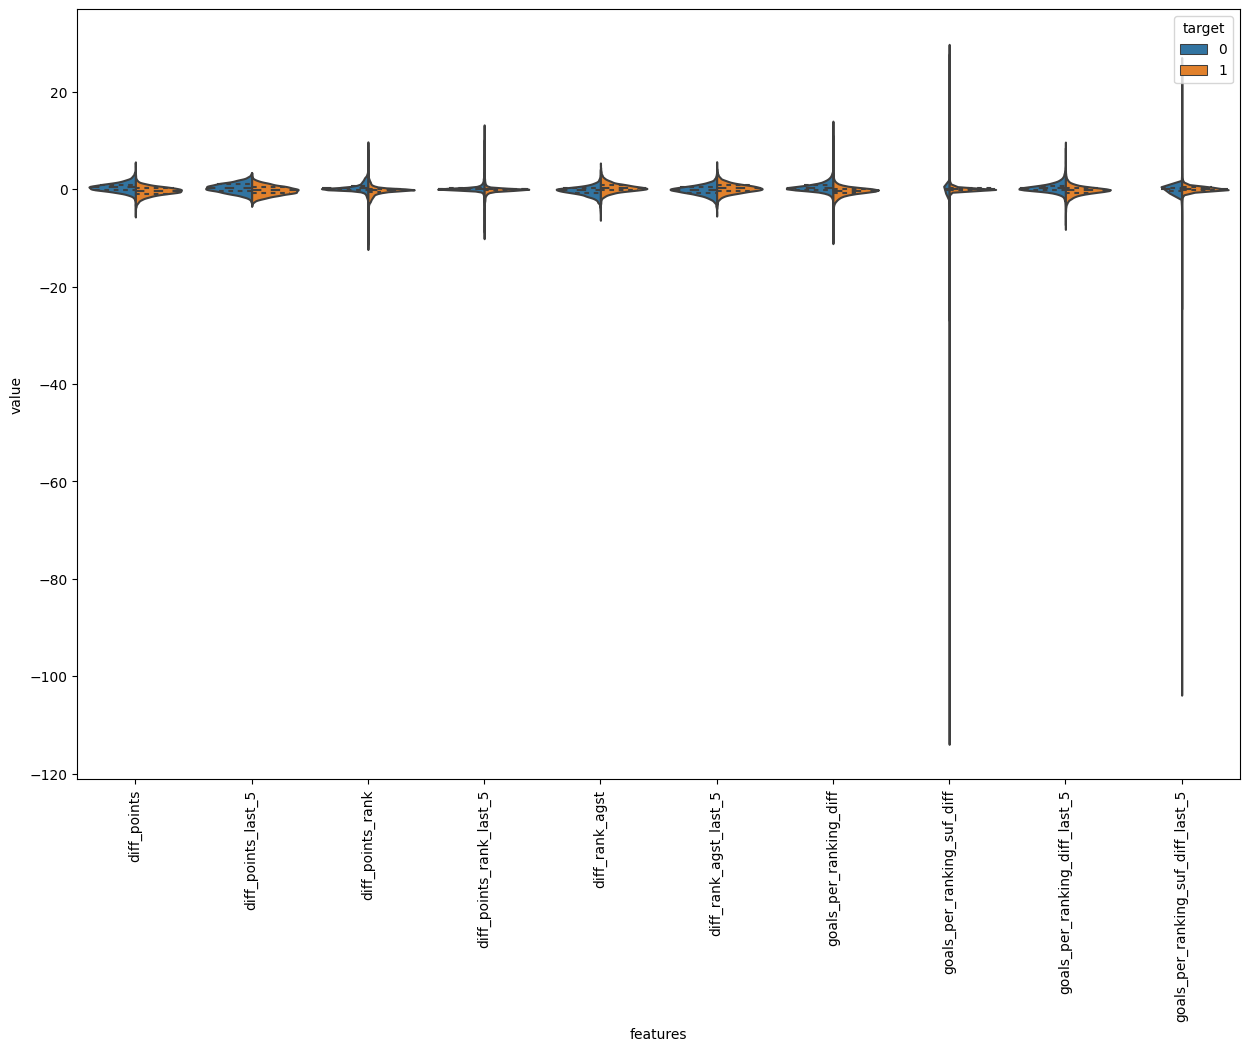

In [59]:
data_diffs = diff.iloc[:, -10:]
scaled = (data_diffs - data_diffs.mean()) / data_diffs.std()
scaled["target"] = data2["target"]
violin = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="target", data=violin,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

Due to the low values, the violin plot was not a good choice to analyze if features are really separating the data in this case. We will see then the boxplot:

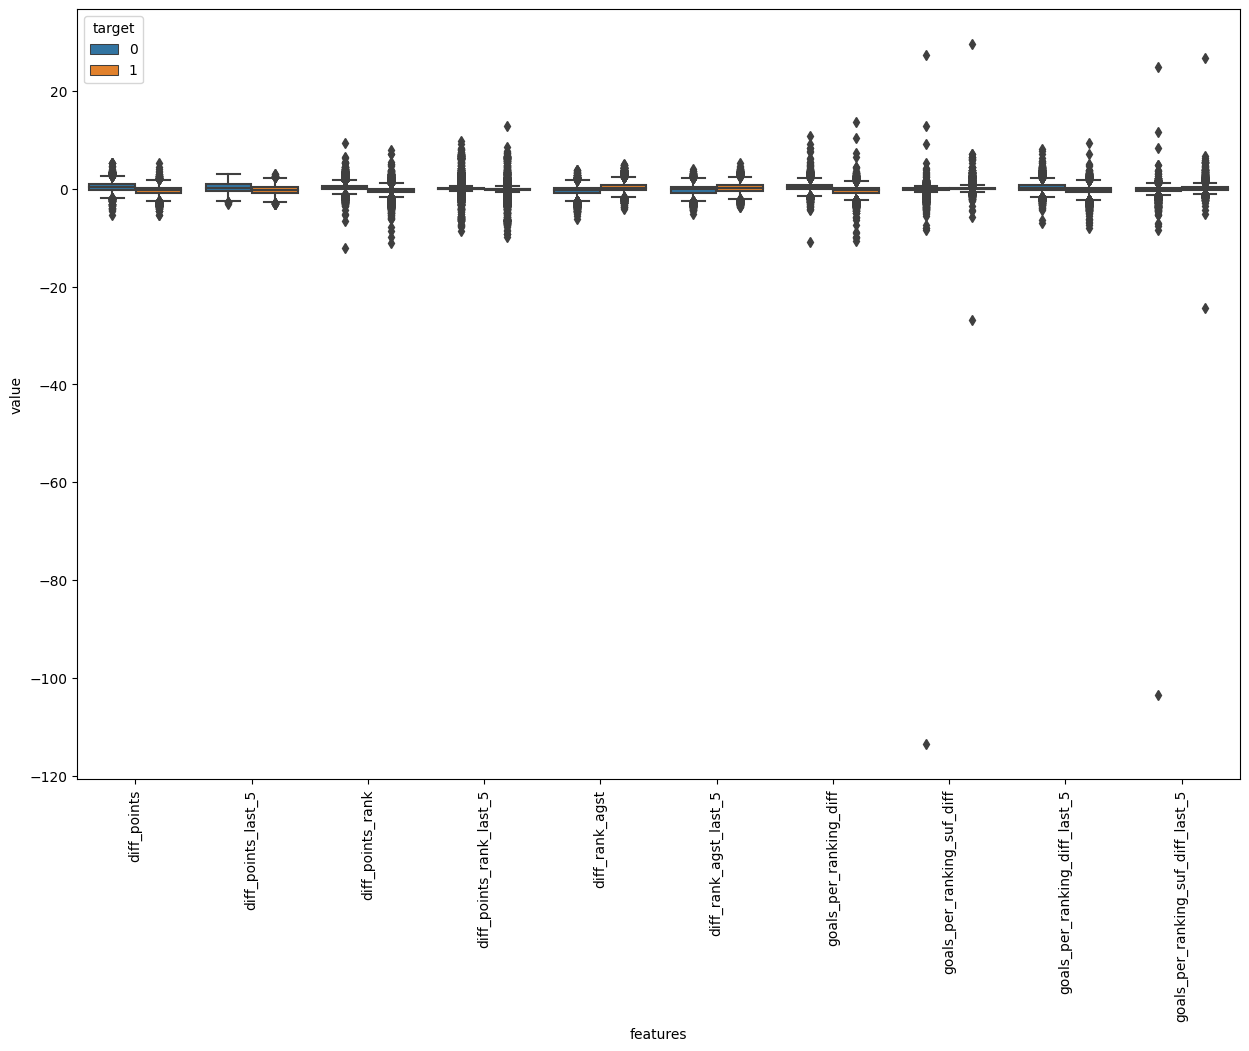

In [60]:
plt.figure(figsize=(15,10))
sns.boxplot(x="features", y="value", hue="target", data=violin)
plt.xticks(rotation=90)
plt.show()

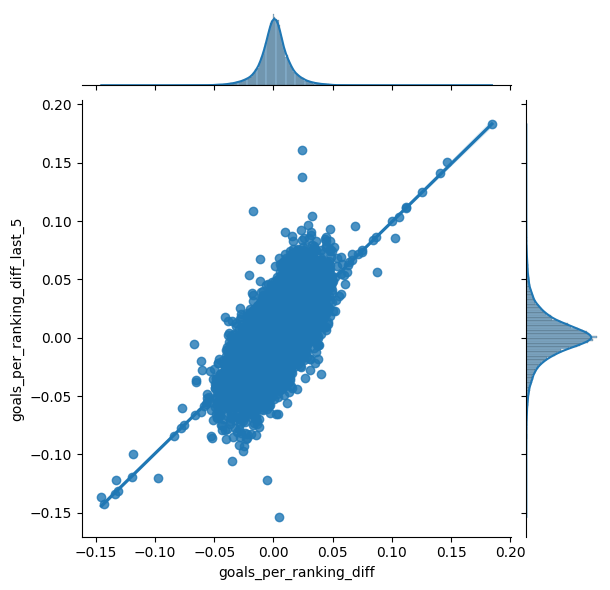

In [61]:
sns.jointplot(data=data_diffs, x='goals_per_ranking_diff', y='goals_per_ranking_diff_last_5', kind='reg')
plt.show()

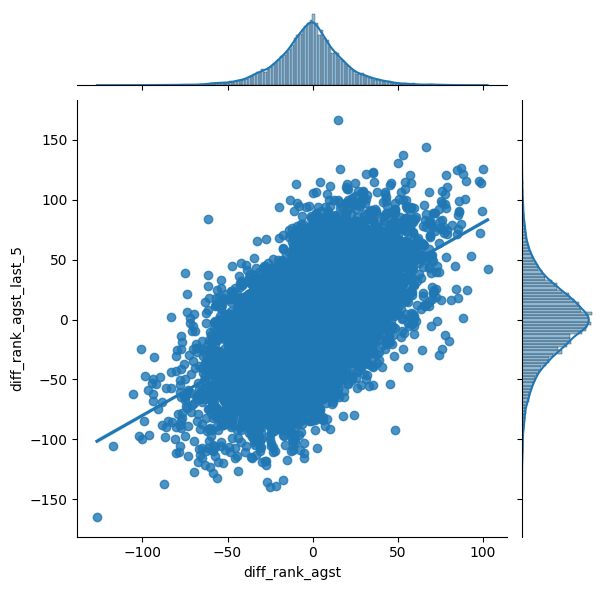

In [62]:
sns.jointplot(data = data_diffs, x = 'diff_rank_agst', y = 'diff_rank_agst_last_5', kind="reg")
plt.show()

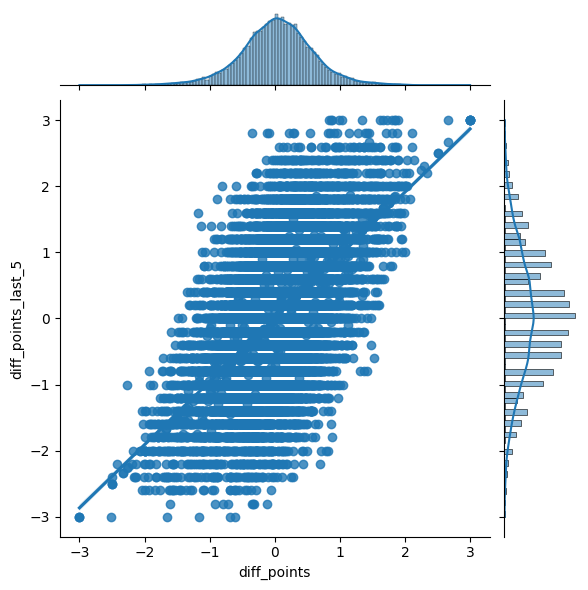

In [63]:
sns.jointplot(data = data_diffs, x = 'diff_points', y = 'diff_points_last_5', kind="reg")
plt.show()

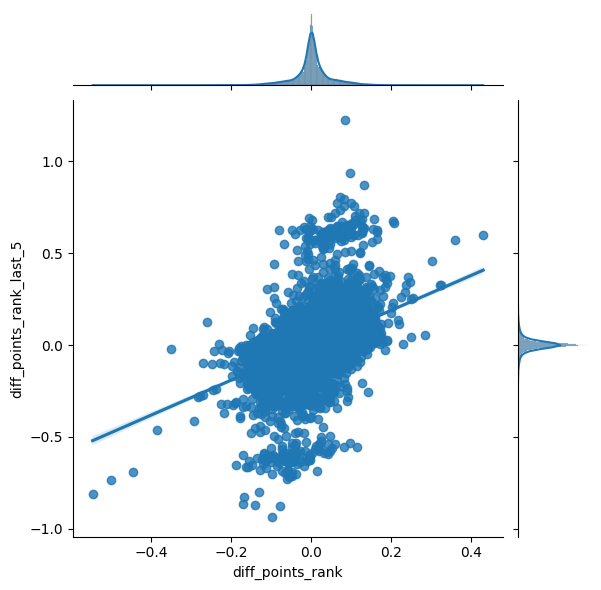

In [64]:
sns.jointplot(data = data_diffs, x = 'diff_points_rank', y = 'diff_points_rank_last_5', kind="reg")
plt.show()

Based on that, final features are:

* rank_diff
* goals_diff
* goals_diff_last_5
* goals_suf_diff
* goals_suf_diff_last_5
* diff_rank_agst
* diff_rank_agst_last_5
* goals_per_ranking_diff
* diff_points_rank
* diff_points_rank_last_5
* is_friendly

In [203]:
def create_data(df):
        columns = ["date", "home_team", "away_team", "home_score", "away_score", "target", "rank_diff",
                   "home_goals_mean", "home_rank_mean", "away_goals_mean",
                   "away_rank_mean", "home_rank_mean_last_5", "away_rank_mean_last_5",
                   "home_goals_suf_mean", "away_goals_suf_mean", "home_goals_mean_last_5",
                   "away_goals_mean_last_5", "home_goals_suf_mean_last_5", "away_goals_suf_mean_last_5",
                   "home_points_rank_mean", "home_points_rank_mean_last_5",
                   "away_points_rank_mean", "away_points_rank_mean_last_5","is_friendly_0", "is_friendly_1"]

        base = df.loc[:, columns]
        base = base[base['date'] > '2018-01-01']
        base.loc[:, 'goals_diff'] = base["home_goals_mean"] - base["away_goals_mean"]
        base.loc[:, "goals_diff_last_5"] = base["home_goals_mean_last_5"] - base["away_goals_mean_last_5"]
        base.loc[:, "goals_suf_diff"] = base["home_goals_suf_mean"] - base["away_goals_suf_mean"]
        base.loc[:, "goals_suf_diff_last_5"] = base["home_goals_suf_mean_last_5"] - base["away_goals_suf_mean_last_5"]
        base.loc[:, "goals_per_ranking_diff"] = (base["home_goals_mean"] / base["home_rank_mean"]) - (base["away_goals_mean"] / base["away_rank_mean"])
        base.loc[:, "diff_rank_agst"] = base["home_rank_mean"] - base["away_rank_mean"]
        base.loc[:, "diff_rank_agst_last_5"] = base["home_rank_mean_last_5"] - base["away_rank_mean_last_5"]
        base.loc[:, "diff_points_rank"] = base["home_points_rank_mean"] - base["away_points_rank_mean"]
        base.loc[:, "diff_points_rank_last_5"] = base["home_points_rank_mean_last_5"] - base["away_points_rank_mean_last_5"]
        
        data = base[['home_team', 'away_team', 'rank_diff', 'target', 'goals_diff', 'goals_diff_last_5', 'goals_suf_diff', 'goals_suf_diff_last_5',
                    'goals_per_ranking_diff', 'diff_rank_agst', 'diff_rank_agst_last_5', 'diff_points_rank',
                    'diff_points_rank_last_5', 'is_friendly_0', 'is_friendly_1']]
        return data.reset_index(drop=True)
        

In [204]:
data = create_data(df)

In [205]:
data.head()

,home_team,away_team,rank_diff,target,goals_diff,goals_diff_last_5,goals_suf_diff,goals_suf_diff_last_5,goals_per_ranking_diff,diff_rank_agst,diff_rank_agst_last_5,diff_points_rank,diff_points_rank_last_5,is_friendly_0,is_friendly_1
0,Iraq,United Arab Emirates,6.0,1,-0.058181,1.4,-0.118125,0.6,-0.002254,9.047482,-5.8,-0.003051,0.003969,1,0
1,Oman,Bahrain,-14.0,0,0.168450,0.8,-0.148320,0.4,0.001680,0.856102,1.4,0.001927,0.005728,1,0
2,Oman,United Arab Emirates,28.0,1,-0.055855,1.2,-0.130201,0.6,-0.001741,6.087139,24.4,-0.001922,0.000474,1,0
3,Estonia,Sweden,71.0,1,-0.744760,-1.2,0.750894,0.4,-0.020646,20.855369,108.8,-0.050826,-0.056526,0,1
4,Denmark,Sweden,-6.0,1,-0.012166,0.2,0.081662,0.0,0.002461,-3.746658,-9.4,0.026137,-0.001324,0,1


## The model

Now, that we have the data ready, we can start modeling.

Now you are ready to do stratified sampling based on the income category. For this we can use Scikit-Learn’s StratifiedShuffleSplit class:

In [206]:
data['goals_diff'].std()

0.4829324484066768

<AxesSubplot: >

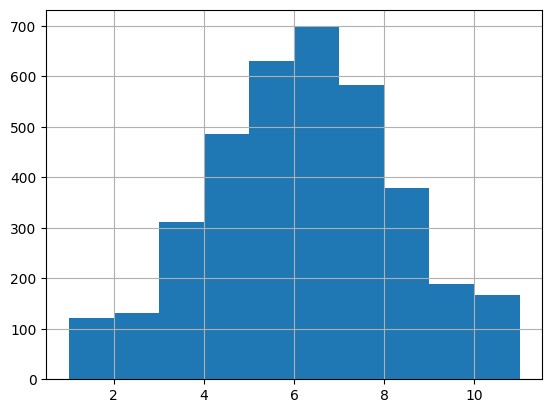

In [207]:
data['strata'] = pd.cut(data['goals_diff'], 
                        bins=[-np.inf, -0.8, -0.6, -0.4, -0.2, 0.,0.2, 0.4, 0.6, 0.8, 1, np.inf],
                        labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
data['strata'].hist()

In [208]:
data.isna().sum()

home_team                  0
away_team                  0
rank_diff                  0
target                     0
goals_diff                 0
goals_diff_last_5          0
goals_suf_diff             0
goals_suf_diff_last_5      0
goals_per_ranking_diff     0
diff_rank_agst             0
diff_rank_agst_last_5      0
diff_points_rank           0
diff_points_rank_last_5    0
is_friendly_0              0
is_friendly_1              0
strata                     0
dtype: int64

In [209]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data, data['strata']):
    strata_train_set = data.loc[train_index]
    strata_test_set = data.loc[test_index]

In [210]:
strata_train_set = strata_train_set.drop('strata', axis=1)
strata_test_set = strata_test_set.drop('strata', axis=1)

In [211]:
x_test = strata_test_set.drop(['home_team', 'away_team', 'target'], axis=1)
y_test = np.ravel(strata_test_set[['target']].to_numpy())

In [212]:
x_train = strata_train_set.drop(['home_team', 'away_team', 'target'], axis=1)
y_train = np.ravel(strata_train_set[['target']].to_numpy())

In [213]:
cols = x_train.columns

pipeline = ColumnTransformer([
    ('num', StandardScaler(), cols)
])

In [214]:
x_train = pipeline.fit_transform(x_train)

In [215]:
y_train.shape

(2952,)

Select a model to check a bit how it is performin

In [227]:
from sklearn.ensemble import RandomForestClassifier,\
                             GradientBoostingClassifier
import lightgbm as lgb

In [230]:
light = lgb.LGBMClassifier(random_state=42)
params = {'learning_rate': [0.01], 'n_estimators': [8, 24],
                   'num_leaves': [6, 8, 12, 16], 'boosting_type': ['gbdt'], 
                   'objective': ['binary'], 'seed': [500],
                   'colsample_bytree': [0.65, 0.75, 0.8], 
                   'subsample': [0.7, 0.75], 'reg_alpha': [1, 2, 6],
                   'reg_lambda': [1, 2, 6]}

light_cv = GridSearchCV(light, params, n_jobs=-1, cv=3, verbose=False)
light_cv.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=LGBMClassifier(random_state=42), n_jobs=-1,
             param_grid={'boosting_type': ['gbdt'],
                         'colsample_bytree': [0.65, 0.75, 0.8],
                         'learning_rate': [0.01], 'n_estimators': [8, 24],
                         'num_leaves': [6, 8, 12, 16], 'objective': ['binary'],
                         'reg_alpha': [1, 2, 6], 'reg_lambda': [1, 2, 6],
                         'seed': [500], 'subsample': [0.7, 0.75]},
             verbose=False)

In [231]:
light = light_cv.best_estimator_
light

LGBMClassifier(colsample_bytree=0.8, learning_rate=0.01, n_estimators=24,
               num_leaves=12, objective='binary', random_state=42, reg_alpha=1,
               reg_lambda=2, seed=500, subsample=0.7)

In [217]:
gb = GradientBoostingClassifier(random_state=42)
params = {"learning_rate": [0.01, 0.1, 0.5],
          "min_samples_split": [5, 10],
          "min_samples_leaf": [3, 5],
          "max_depth":[3,5,10],
          "max_features":["sqrt"],
          "n_estimators":[100, 200]
         }

gb_cv = GridSearchCV(gb, params, n_jobs=-1, cv=3, verbose=False)
gb_cv.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.5],
                         'max_depth': [3, 5, 10], 'max_features': ['sqrt'],
                         'min_samples_leaf': [3, 5],
                         'min_samples_split': [5, 10],
                         'n_estimators': [100, 200]},
             verbose=False)

In [218]:
gb = gb_cv.best_estimator_
gb

GradientBoostingClassifier(learning_rate=0.01, max_depth=5, max_features='sqrt',
                           min_samples_leaf=5, min_samples_split=5,
                           random_state=42)

In [219]:
rf = RandomForestClassifier(random_state=42)
params_rf = {"max_depth": [20],
             "min_samples_split": [10],
             "max_leaf_nodes": [175],
             "min_samples_leaf": [5],
             "n_estimators": [250],
             "max_features": ["sqrt"],
            }
rf_cv = GridSearchCV(rf, params_rf, cv=3, n_jobs=-1, verbose=False)
rf_cv.fit(x_train, np.ravel(y_train))

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [20], 'max_features': ['sqrt'],
                         'max_leaf_nodes': [175], 'min_samples_leaf': [5],
                         'min_samples_split': [10], 'n_estimators': [250]},
             verbose=False)

In [220]:
rf = rf_cv.best_estimator_
rf

RandomForestClassifier(max_depth=20, max_leaf_nodes=175, min_samples_leaf=5,
                       min_samples_split=10, n_estimators=250, random_state=42)

In [221]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

In [222]:
def analyze(model, x_train, x_test):
    x_test = pipeline.transform(x_test)
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(x_test)[:,1]) #test AUC
    plt.figure(figsize=(15,10))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label="test")

    fpr_train, tpr_train, _ = roc_curve(y_train, model.predict_proba(x_train)[:,1]) #train AUC
    plt.plot(fpr_train, tpr_train, label="train")
    auc_test = roc_auc_score(y_test, model.predict_proba(x_test)[:,1])
    auc_train = roc_auc_score(y_train, model.predict_proba(x_train)[:,1])
    plt.legend()
    plt.title('AUC score is %.2f on test and %.2f on training'%(auc_test, auc_train))
    plt.show()
    
    plt.figure(figsize=(15, 10))
    cm = confusion_matrix(y_test, model.predict(x_test))
    sns.heatmap(cm, annot=True, fmt="d")

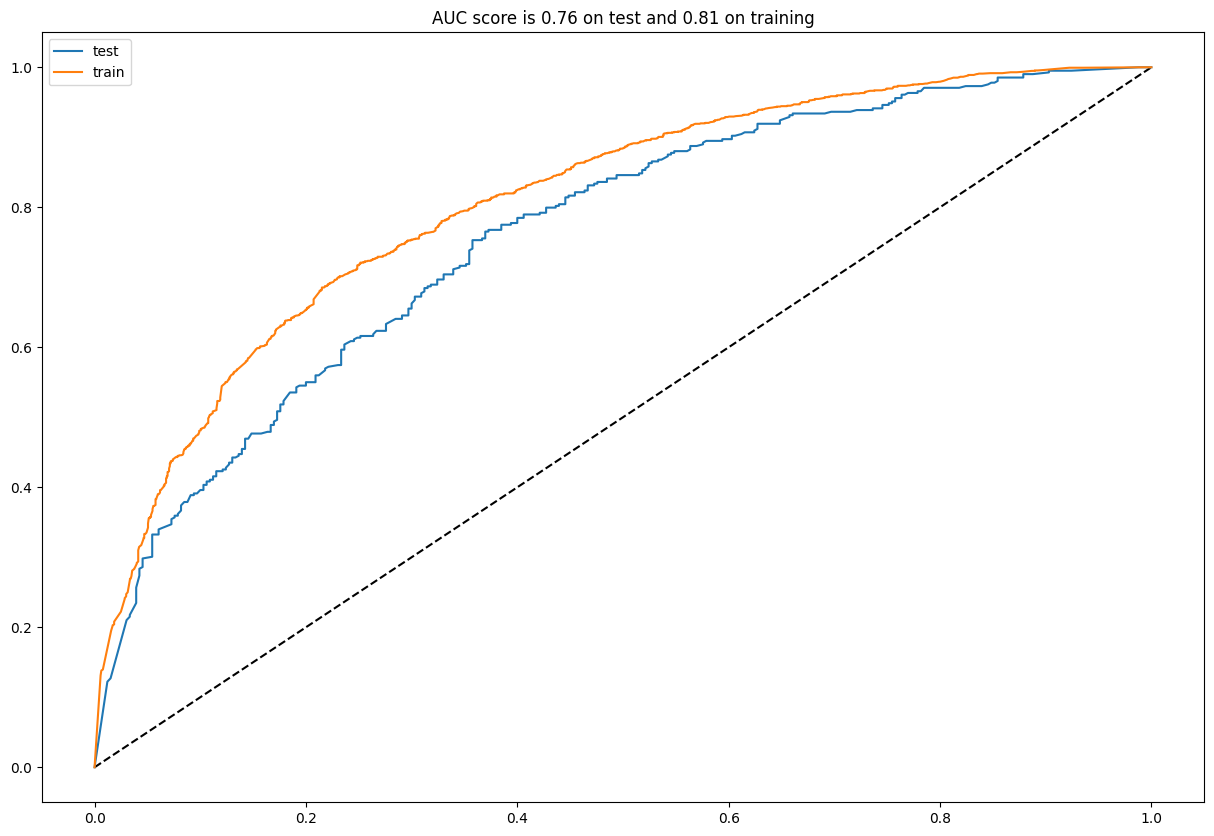

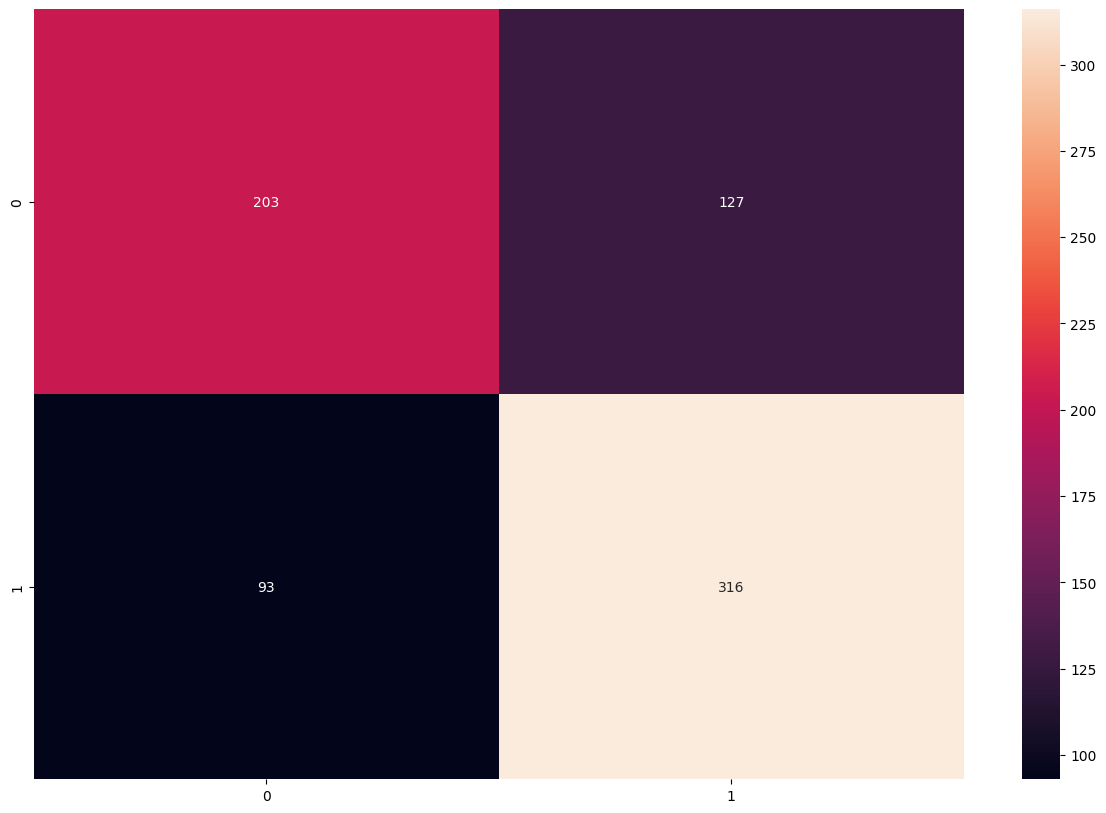

In [232]:
analyze(light, x_train, x_test)

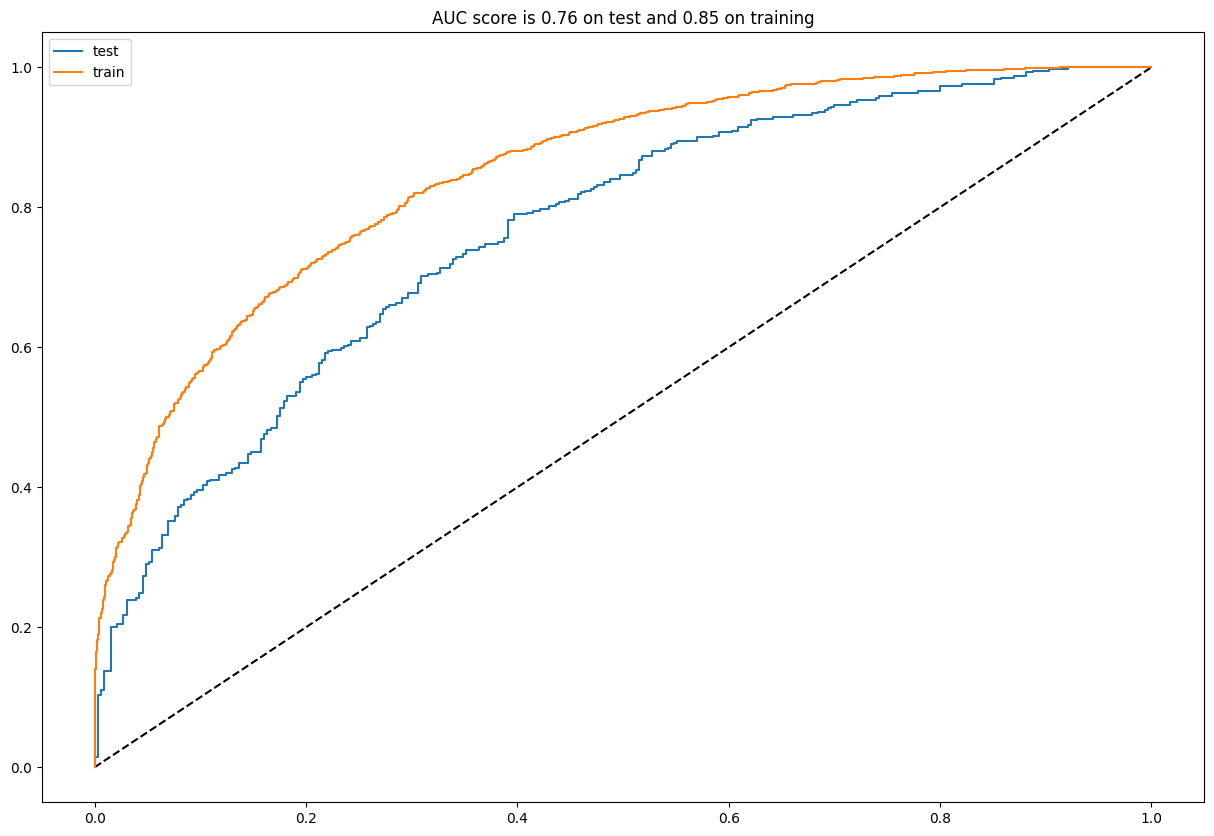

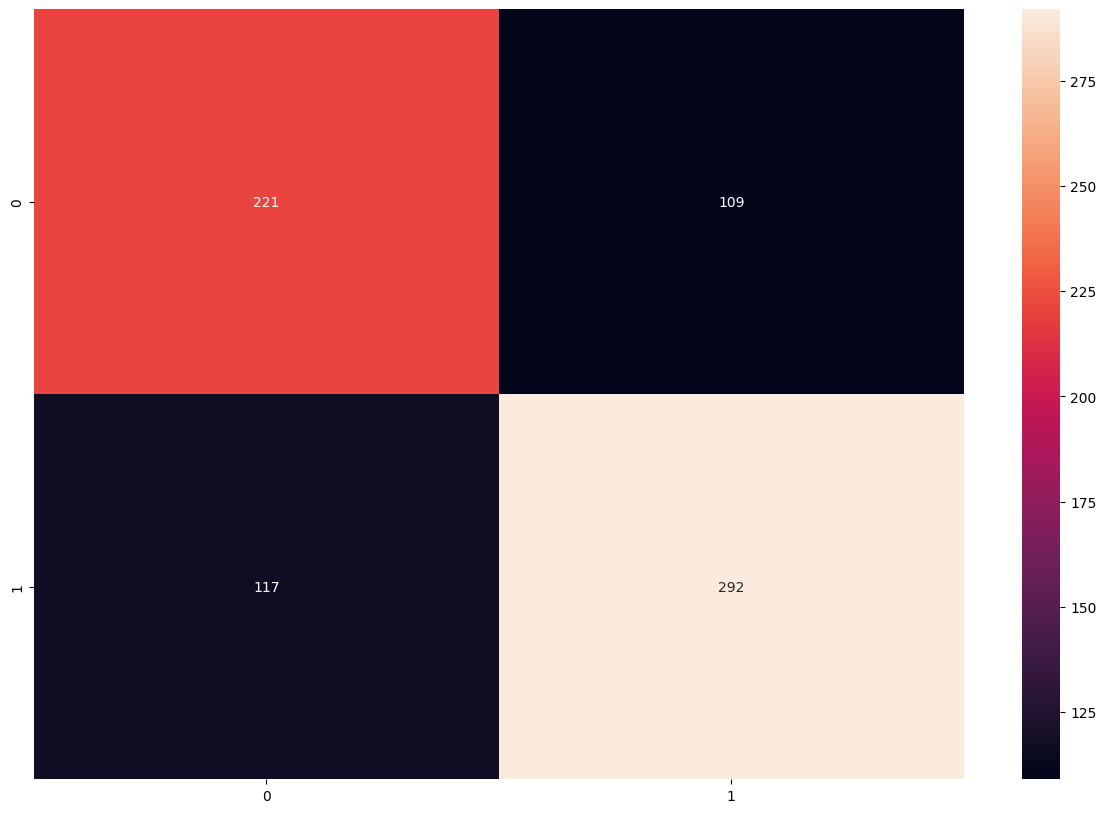

In [223]:
analyze(gb, x_train, x_test)

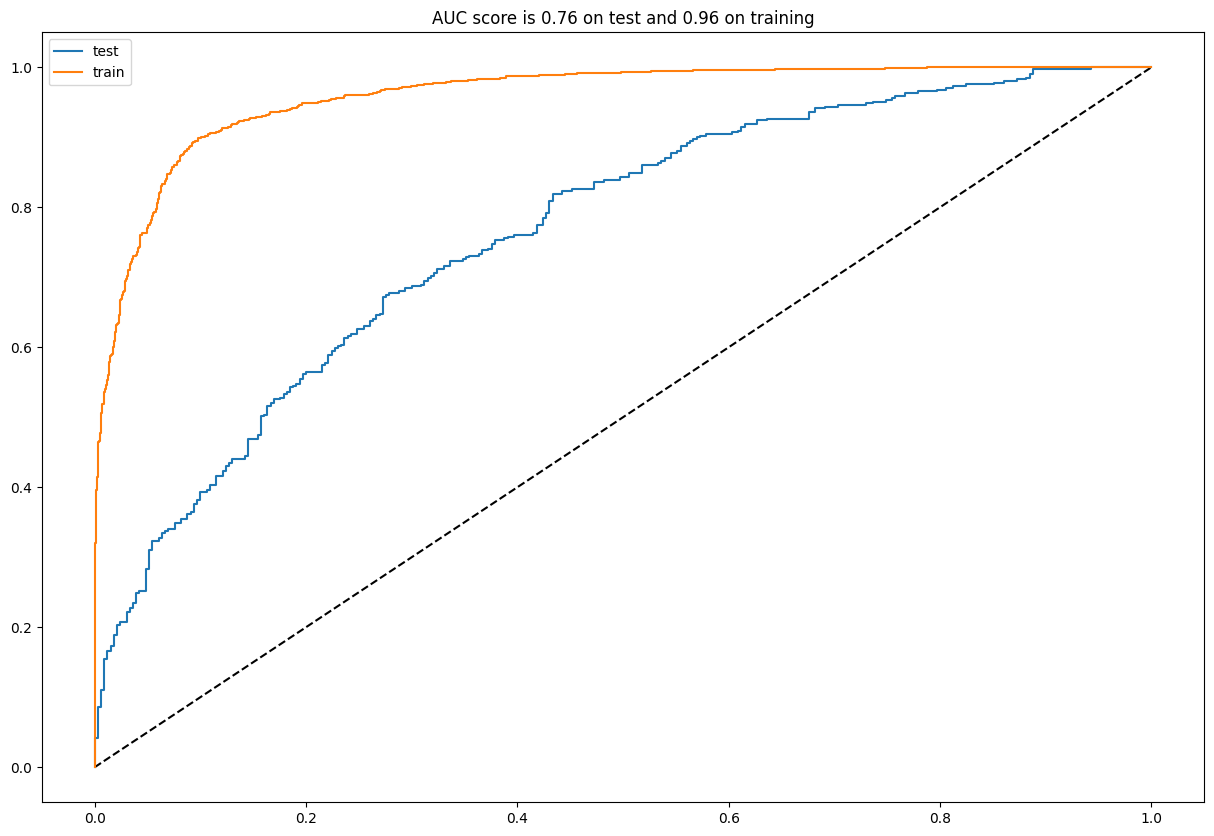

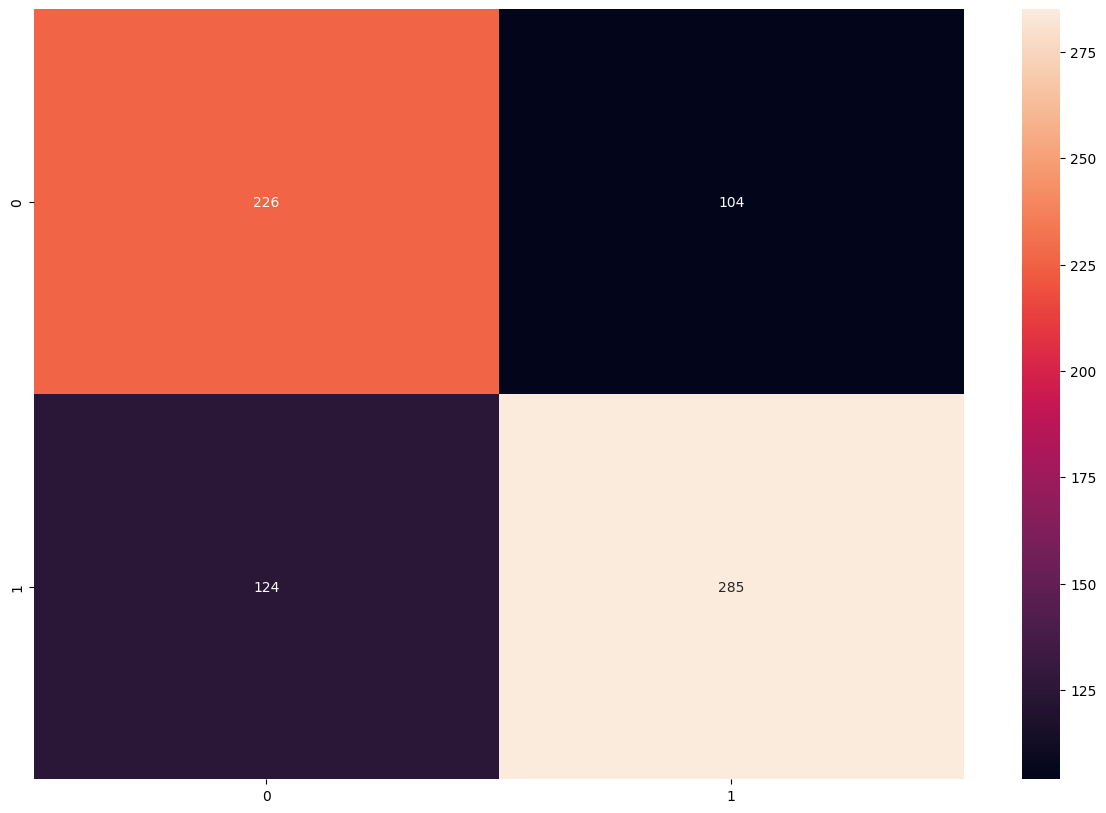

In [224]:
analyze(rf, x_train, x_test)